<a href="https://colab.research.google.com/github/atfrank/ss2cs/blob/Kexin-thesis/ss2cs_aaron_manuscript.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problems I found when I worked on this project: </br>


1.   Chemical shifts in chemical-shifts-correction repo are different from cs2bps project;</br>
    I investigated on gollum for 5KH8 and 5A17, confirming that CS2Structure folder and cs2bps chemical shifts were correct and the warning I got during reference correction was due to R version.
2.   Several rnas like 2LU0 have multiple values for same atoms; -> check if other RNAs have same issues.
3.   Non-argument warning during chemical shifts reference correction -> R version;
4.   cs_data in gollum are not corrected!!!


In [ ]:
import os.path
import sys
import numpy as np
import pandas as pd
from google.colab import files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
def get_resname_int(resname):
    if resname == 'A' or resname == 'ADE':
        return 1
    elif resname == 'G' or resname == 'GUA':
        return 2
    elif resname == 'C' or resname == 'CYT':
        return 3
    elif resname == 'U' or resname == 'URA':
        return 4

def get_resname_char(resname):
    if resname == 1:
        return 'ADE'
    elif resname == 2:
        return 'GUA'
    elif resname == 3:
        return 'CYT'
    elif resname == 4:
        return 'URA'

def extractCT(ct_path,rna):
    # function to extract features from DSSR annotated secondary structure (.ct)
    df = pd.read_csv(ct_path, delim_whitespace=True,header=None,skiprows=1)
    length = len(df)
    df.columns = ['resid','resname','i_minus_1','i_plus_1','i_bp','resid2']

    #residue name of residue i
    i_resname = df['resname'].apply(lambda x: get_resname_int(x)) # Series
    i_resname_char = df['resname'].apply(lambda x: get_resname_char(get_resname_int(x))) 

    #residue that base paired to i is (resname instead of resid):
    i_bp = df['i_bp']
    i_bp_resname = []
    for i in range(length):
      if i_bp[i] == 0:
        i_bp_resname.append(0)
      else:
        i_bp_resname.append(get_resname_int(df[df['resid']==i_bp[i]]['resname'].values[0]))
    i_bp_resname = pd.Series(i_bp_resname)

    #residue that base paired to i-1 is:
    i_minus_1_bp = df['i_bp'].values.tolist()
    i_minus_1_bp = [0]+i_minus_1_bp # add 0 at the begining
    i_minus_1_bp.pop() # delete last element
    i_minus_1_bp_resname = []
    for i in range(length):
      if i_minus_1_bp[i] == 0:
        i_minus_1_bp_resname.append(0)
      else:
        i_minus_1_bp_resname.append(get_resname_int(df[df['resid']==i_minus_1_bp[i]]['resname'].values[0]))
    i_minus_1_bp_resname = pd.Series(i_minus_1_bp_resname)

    #residue that base paired to i+1 is:
    i_plus_1_bp = df['i_bp'].values.tolist()
    i_plus_1_bp = i_plus_1_bp+[0] # add 0 at the end
    i_plus_1_bp.pop(0) # delete last element
    i_plus_1_bp_resname = []
    for i in range(length):
      if i_plus_1_bp[i] == 0:
        i_plus_1_bp_resname.append(0)
      else:
        i_plus_1_bp_resname.append(get_resname_int(df[df['resid']==i_plus_1_bp[i]]['resname'].values[0]))
    i_plus_1_bp_resname = pd.Series(i_plus_1_bp_resname)

    #residue name of i-1
    i_minus_1_resname = i_resname.values.tolist()
    i_minus_1_resname = [0] + i_minus_1_resname
    i_minus_1_resname.pop()
    i_minus_1_resname = pd.Series(i_minus_1_resname)

    #residue name of i+1
    i_plus_1_resname = i_resname.values.tolist()
    i_plus_1_resname = i_plus_1_resname+[0]
    i_plus_1_resname.pop(0)
    i_plus_1_resname = pd.Series(i_plus_1_resname) 

    #the previous residue of the residue base paired to i: i_bp_minus_1
    i_bp_minus_1 = list(map(lambda x: x-1, i_bp.values.tolist()))
    i_bp_minus_1_resname = []
    for i in range(length):
      if i_bp_minus_1[i]==-1 or i_bp_minus_1[i]==0:
        i_bp_minus_1_resname.append(0)
      else:
        i_bp_minus_1_resname.append(get_resname_int(df[df['resid']==i_bp_minus_1[i]]['resname'].values[0]))
    i_bp_minus_1_resname = pd.Series(i_bp_minus_1_resname)

    #the next residue of the residue base paired to i: i_bp_plus_1
    i_bp_plus_1 = list(map(lambda x: x+1, i_bp.values.tolist()))
    i_bp_plus_1_resname = []
    for i in range(length):
      if i_bp_plus_1[i]==1 or i_bp_plus_1[i]==(length+1):
        i_bp_plus_1_resname.append(0)
      else:
        i_bp_plus_1_resname.append(get_resname_int(df[df['resid']==i_bp_plus_1[i]]['resname'].values[0]))  
    i_bp_plus_1_resname = pd.Series(i_bp_plus_1_resname)

    #i_bp_prev_bp
    i_bp_minus_1_bp_resname = []
    for i in range(length):
      if i_bp_minus_1[i]==-1 or i_bp_minus_1[i]==0:
        i_bp_minus_1_bp_resname.append(0)
      else:
        i_bp_minus_1_bp = df[df['resid']==i_bp_minus_1[i]]['i_bp'].values[0]
        if i_bp_minus_1_bp == 0:
          i_bp_minus_1_bp_resname.append(0)
        else:
          i_bp_minus_1_bp_resname.append(get_resname_int(df[df['resid']==i_bp_minus_1_bp]['resname'].values[0]))
    i_bp_minus_1_bp_resname = pd.Series(i_bp_minus_1_bp_resname)

    #i_bp_next_bp
    i_bp_plus_1_bp_resname = []
    for i in range(length):
      if i_bp_plus_1[i]==1 or i_bp_plus_1[i]==(length+1):
        i_bp_plus_1_bp_resname.append(0)
      else:
        i_bp_plus_1_bp = df[df['resid']==i_bp_plus_1[i]]['i_bp'].values[0]
        if i_bp_plus_1_bp == 0:
          i_bp_plus_1_bp_resname.append(0)
        else:
          i_bp_plus_1_bp_resname.append(get_resname_int(df[df['resid']==i_bp_plus_1_bp]['resname'].values[0]))  
    i_bp_plus_1_bp_resname = pd.Series(i_bp_plus_1_bp_resname) 

    # create other information as Series
    rnaid = pd.Series([rna]*length)
    total_length = pd.Series([length]*length)
    resid = df['resid']
    resname = df['resname']

    #print(features)
    features = pd.concat([rnaid, total_length, resid, resname, i_resname, i_minus_1_resname,
    i_plus_1_resname, i_bp_resname, i_minus_1_bp_resname, i_plus_1_bp_resname, i_bp_minus_1_resname,
    i_bp_plus_1_resname, i_bp_minus_1_bp_resname, i_bp_plus_1_bp_resname], axis=1)
    features.columns = ["id","length","resid","i_resname_char","i_resname","i_minus_1_resname","i_plus_1_resname",
                        "i_bp_resname", "i_minus_1_bp_resname", "i_plus_1_bp_resname", "i_bp_minus_1_resname",
                        "i_bp_plus_1_resname", "i_bp_minus_1_bp_resname", "i_bp_plus_1_bp_resname"]
    return features

def rename_nucleus_type(nucleus):
  if "'" in nucleus:
    return nucleus.replace("'","p")
  else:
    return nucleus
    
"""
def correct_chemical_shifts_offset(expcs, rna):
  if rna in ["2MNC","2NC0","2NC1","5UZT","2NBY","2NBZ"]:
    newResId = 0
    for oldResId in expcs.resid.unique():
      newResId = newResId+1
      expcs.loc[expcs.resid==oldResId,'resid'] = newResId
  return expcs
"""
  

'\ndef correct_chemical_shifts_offset(expcs, rna):\n  if rna in ["2MNC","2NC0","2NC1","5UZT","2NBY","2NBZ"]:\n    newResId = 0\n    for oldResId in expcs.resid.unique():\n      newResId = newResId+1\n      expcs.loc[expcs.resid==oldResId,\'resid\'] = newResId\n  return expcs\n'

# Prepare input

## Prepare secondary structure data

In [ ]:
rnas = ['1A60', '1HWQ', '1JO7', '1KKA', '1L1W', '1LC6', '1LDZ', '1MFY', '1NA2',
'1NC0', '1OW9', '1PJY', '1Q75', '1R7W', '1R7Z', '1SCL', '1SY4', '1SYZ', '1UUU',
'1XHP', '1YMO', '1YSV', '1Z2J', '1Z30', '1ZC5', '28SP', '28SR', '2F87', '2FDT',
'2GVO', '2JR4', '2JTP', '2JWV', '2JYM', '2K66', '2KEZ', '2KF0', '2KOC', '2KXM',
'2KZL', '2L3E', '2L5Z', '2L6I', '2L8H', '2LAC', '2LBJ', '2LBK', '2LBL', '2LDL',
'2LDT', '2LHP', '2LI4', '2LJJ', '2LK3', '2LP9', '2LPA', '2LPS', '2LQZ', '2LU0',
'2LUB', '2LUN', '2LV0', '2M12', '2M21', '2M22', '2M4W', '2M5U', '2M8K', '2MEQ', 
'2MFD', '2MHI', '2MIS', '2MNC', '2MTJ', '2MXL', '2N1Q', '2N2O', '2N2P', '2N3Q', 
'2N3R', '2N4L', '2N6S', '2N6T', '2N6W', '2N6X', '2NBY', '2NBZ', '2NC0', '2NC1', 
'2NCI', '2O33', '2QH2', '2QH3', '2QH4', '2RVO', '2Y95', '4A4S', '4A4T', '4A4U', 
'5A17', '5A18', '5IEM', '5KH8', '5KQE', '5UF3', '5UZT', '5V16', '5WQ1']

In [ ]:
# featurize
DIR_PATH = 'drive/My Drive/RESEARCH/ss2cs/'
train_X = pd.DataFrame([])
for rna in rnas:
    features = extractCT(DIR_PATH + 'info/' + rna + '.ct',rna)
    train_X = pd.concat([train_X, features],ignore_index=True)

train_X.drop('i_resname_char', axis = 1, inplace=True)

In [ ]:
# save output
train_X.to_csv(DIR_PATH+'data/train_X_NEW.csv',sep=' ',header=True, index=False)
#files.download(DIR_PATH+'data/train_X.csv') # save to local GitHub repo

## Prepare chemical shifts

In [ ]:
cs = pd.DataFrame([])
for rna in rnas:
  expcs = pd.read_csv(DIR_PATH+"info/corrected_chemical_shifts/measured_shifts_"+rna+".dat", header=None, delim_whitespace=True)
  expcs.columns = ['resname','resid','nucleus','expcs','error']
  expcs.drop_duplicates(inplace=True)
  #if rna in ["2MNC","2NBY","2NBZ","2NC0","2NC1","5UZT"]:  
   # correct_chemical_shifts_offset(expcs, rna)
  # DEBUG
  expcs.sort_values(by=['resid'], inplace=True)
  expcs.reset_index(inplace=True,drop=True)
  #if expcs.resid[0]!=1:
  #  print(rna)
  expcs['id'] = rna
  cs = pd.concat([cs, expcs], ignore_index=True)

# remove 5 RNAs whose measured chemical shifts contain ambigous values
indexNames = cs[(cs.id =="1R7W") | (cs.id=="1R7Z") | (cs.id=="1Z30") | (cs.id=="2LK3") | (cs.id=="2LU0") | (cs.id=="5KH8")].index
cs.drop(indexNames , inplace=True,index=None)

cs.to_csv(DIR_PATH+'data/cs_all_NEW.info',sep=' ',header=True,index=False)
#files.download(DIR_PATH+'data/cs_all.info') # save to local GitHub repo

Some chemical shifts had offset issues </br>
2LDL: check, do nothing </br>
2MNC: expcs 8-23, ss 1-16; has all residues, directly offset to 1-16 </br> 
2MXL: check, do nothing </br>
2NBY: expcs 693-730, ss 1-39; missing last one, offset to 1 </br> 
2NBZ: expcs 730-768, ss 1-40; missing last one, offset to 1 </br>
2NC0: expcs 681-786, ss 1-28; has all residues, directly offset to 1-28 </br> 
2NC1: expcs 680-787, ss 1-67; has all residues, directly offset to 1-67 </br>
5UZT: expcs 22-52, ss 1-31; has all residues, directly offset to 1-31 </br>

## Combine structure features and chemical shifts for each nucleus type

In [ ]:
nuclei = ["C1'", "C2'", "C3'", "C4'", "C5'","C2","C5","C6","C8",
          "H1'", "H2'", "H3'","H4'", "H5'","H5''","H2","H5","H6","H8"]
train_X = pd.read_csv(DIR_PATH+"data/train_X_NEW.csv", delim_whitespace=True, header=0)
for nucleus in nuclei:
  cs_selected = cs[cs.nucleus == nucleus]
  #set(train_X.columns).intersection(set(cs_selected.columns)) 
  df_combined = pd.merge(train_X, cs_selected)
  df_combined.drop(['resid','resname','nucleus','error'],axis=1,inplace=True)
  nucleus_renamed = rename_nucleus_type(nucleus)
  df_combined.to_csv(DIR_PATH+'data/'+nucleus_renamed+'.csv',sep=' ',header=True, index=False)

In [ ]:
for nucleus in nuclei:
  print(nucleus)
  df = pd.read_csv(DIR_PATH+'data/'+nucleus.replace("'","p")+'.csv',delim_whitespace=True,header=0)
  print(df.shape)

C1'
(1834, 13)
C2'
(1625, 13)
C3'
(1520, 13)
C4'
(1486, 13)
C5'
(1245, 13)
C2
(572, 13)
C5
(973, 13)
C6
(998, 13)
C8
(1086, 13)
H1'
(3106, 13)
H2'
(2925, 13)
H3'
(2481, 13)
H4'
(2039, 13)
H5'
(1637, 13)
H5''
(1608, 13)
H2
(695, 13)
H5
(1451, 13)
H6
(1521, 13)
H8
(1621, 13)


check diff:</br>  only for H1'
1R7W</br> 
1R7Z</br> 
1Z30</br> 
2LK3</br> 
2LU0</br> 
Chemical shifts for these RNAs contain multiple values for same atom, so they are excluded from training set for now.

# Train models

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from sklearn.externals import joblib
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
def evaluate(nucleus, model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    #print('Model Performance', file=f)  
    print('MAE for '+nucleus+': {:0.4f} ppm.'.format(np.mean(errors)), file = f)
    
def training_cv_score_model(X, y, model):

    scores = cross_val_score(model,
                             X,
                             y.values.flatten(),
                             scoring='neg_mean_absolute_error',
                             cv=10)

    mean_mae = scores.mean()
    sd_mae = scores.std()

    model_name = model.__class__.__name__

    print(f'{model_name}, Average Score : {mean_mae} & Standard Deviation: {sd_mae}')
    print('-'*90)
    return [mean_mae, sd_mae]

def out_of_sample_score(train_features, train_target, test_features, test_target, model):
    """
    This function takes the design matrix and target vector of the validation set,
    along with a classification estimator and
    scores the predicted classes and true values via a balanced accuracy score.
    This score is printed to the end user.
    """

    model_name = model.__class__.__name__

    model.fit(train_features, train_target.values.ravel())

    preds = model.predict(test_features)
    score = mean_absolute_error(y_true=test_target, y_pred=preds)

    print(f'{model_name} with MAE on test set {score}')
    print('-'*90)
    return score

## Baseline Model Selection

In [ ]:
# set drive path
DIR_PATH = 'drive/My Drive/RESEARCH/ss2cs/'
# use total training data to fit one hot encoder
train_X = pd.read_csv(DIR_PATH+'data/train_X_NEW.csv',sep=' ',header=0)
train_X = train_X.drop(['id','length','resid'],axis = 1)
enc = preprocessing.OneHotEncoder(sparse = False)
enc.fit(train_X)

nuclei = ["C1'", "C2'", "C3'", "C4'", "C5'","C2","C5","C6","C8",
          "H1'", "H2'", "H3'","H4'", "H5'","H5''","H2","H5","H6","H8"]
# estimators tested
models = [
      LinearRegression(),  
      Ridge(),
      SVR(),
      RandomForestRegressor(),
      ExtraTreesRegressor(),
      GradientBoostingRegressor()
      ]

# error data frame to store result for each model and each nucleus type
errors_val_all = pd.DataFrame([])
errors_test_all = pd.DataFrame([])

# train each nucleus
for nucleus in nuclei:
    train = pd.read_csv(DIR_PATH+'data/'+nucleus.replace("'","p")+'.csv', sep = ' ', header = 0)
    y = train['expcs']
    X = train.drop(['id','expcs'],axis = 1)
    X_resname = X.drop(['length'],axis=1)
    X_info = X['length']  #did not use rna name
    
    # one hot encoding
    X_resname_enc = pd.DataFrame(enc.transform(X_resname))
    X_enc = pd.concat([X_info, X_resname_enc],axis = 1)

    # tran test split
    X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size = 0.2, random_state=42)

    # start model selection and evluation
    print(nucleus)
    errors_val = []
    errors_test = []
    for model in models:
      # extract model name
      model_name = model.__class__.__name__

      # train set cross validation 
      errors_val.append(training_cv_score_model(X_train, y_train, model)[0])

      # test set error evaluation
      errors_test.append(out_of_sample_score(X_train, y_train, X_test, y_test, model))

    #errors_train_mae[nucleus] = errors_mae
    #errors_train_sd[nucleus] =errors_sd
    errors_val_all[nucleus] = errors_val
    errors_test_all[nucleus] = errors_test

In [ ]:
# rename rows 
errors_val_all.rename(index={0: "Linear", 1: "Ridge", 2: "SVR", 3:"RF", 4:"ET", 5:"GB"}, inplace=True)
errors_test_all.rename(index={0: "Linear", 1: "Ridge", 2: "SVR", 3:"RF", 4:"ET", 5:"GB"}, inplace=True)

# analyze
errors_t = errors_val_all.transpose()
errors_t = errors_t*(-1) # positive MAE
#errors_t.columns = ['LR','Ridge','SVR','RF','ET','GB']
models = errors_t.columns
nuclei_C = ["C1'", "C2'", "C3'", "C4'", "C5'","C2","C5","C6","C8"]
nuclei_H = ["H1'", "H2'", "H3'","H4'", "H5'","H5''","H2","H5","H6","H8"]
errors_C = errors_t.loc[nuclei_C,]
errors_H = errors_t.loc[nuclei_H, ]
errors_t.to_csv(DIR_PATH+'data/train_cv_MAE_NEW.csv', sep=' ', index=False)

# plot cv result
import plotly.graph_objects as go
fig = go.Figure()
for model in models:
  fig.add_trace(go.Scatter(y=errors_C[model],x=errors_C.index,name=model))
#fig.update_xaxes(showgrid=False)
#fig.update_yaxes(showgrid=False)
fig.update_layout(template = 'plotly_white',font=dict(size=20))
fig.show()

# report test result
errors_t = errors_test_all.transpose()
errors_t = errors_t # positive MAE
errors_C = errors_t.loc[nuclei_C,]
errors_H = errors_t.loc[nuclei_H, ]
errors_t.to_csv(DIR_PATH+'data/test_MAE_NEW.csv', sep=' ', index=False)
print(errors_C['RF'].round(2))
print(errors_H['RF'].round(2))
print(errors_H.mean().round(2))
print(errors_C.mean().round(2))

C1'    0.86
C2'    0.61
C3'    1.22
C4'    0.73
C5'    0.93
C2     1.18
C5     0.82
C6     0.82
C8     0.72
Name: RF, dtype: float64
H1'     0.11
H2'     0.12
H3'     0.11
H4'     0.09
H5'     0.14
H5''    0.12
H2      0.13
H5      0.10
H6      0.10
H8      0.12
Name: RF, dtype: float64
Linear    0.13
Ridge     0.13
SVR       0.15
RF        0.11
ET        0.13
GB        0.12
dtype: float64
Linear    0.93
Ridge     0.95
SVR       1.34
RF        0.88
ET        0.96
GB        0.93
dtype: float64


In [ ]:
# rename rows
#errors_train_mae.rename(index={0: "Linear", 1: "Ridge", 2: "SVR", 3:"RF", 4:"ET", 5:"GB"}, inplace=True)
#errors_train_sd.rename(index={0: "Linear", 1: "Ridge", 2: "SVR", 3:"RF", 4:"ET", 5:"GB"}, inplace=True)
#errors_test_mae.rename(index={0: "Linear", 1: "Ridge", 2: "SVR", 3:"RF", 4:"ET", 5:"GB"}, inplace=True)
# save output
#errors_train_mae.to_csv(DIR_PATH+'data/train_mae_NEW.csv', sep=' ', index=False)
#errors_train_sd.to_csv(DIR_PATH+'data/train_sd_NEW.csv',sep=' ',index=False)
#errors_test_mae.to_csv(DIR_PATH+'data/test_mae_NEW.csv',sep=' ',index=False)

NameError: ignored

Random forest base line model beats other models.

## Save random forest models

In [ ]:
# read in data
DIR_PATH = '/content/drive/My Drive/RESEARCH/ss2cs/'

# use total training data to fit one hot encoder
train_X = pd.read_csv(DIR_PATH+'data/train_X.csv',sep=' ',header=0)
train_X = train_X.drop(['id','length','resid'],axis = 1)
enc = preprocessing.OneHotEncoder(sparse = False)
enc.fit(train_X)

# train each nucleus
for nucleus in nuclei:
    train = pd.read_csv(DIR_PATH+'data/'+nucleus.replace("'","p")+'.csv', sep = ' ', header = 0)
    y = train['expcs']
    X = train.drop(['id','expcs'],axis = 1)

    X_resname = X.drop(['length'],axis=1)
    X_info = X['length']  #did not use rna name
  
    X_resname_enc = pd.DataFrame(enc.transform(X_resname))
    X_enc = pd.concat([X_info, X_resname_enc],axis = 1)


    # random forest fitting
    rf = RandomForestRegressor()
    rf.fit(X_enc, y)
    # save the model to disk
    filename = DIR_PATH + 'output/RF_' + nucleus + '.sav'
    pickle.dump(rf, open(filename, 'wb'),-1)

## Plot learning curve

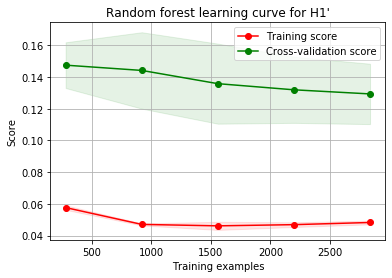

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
# set drive path
DIR_PATH = 'drive/My Drive/ss2cs/'
# use total training data to fit one hot encoder
train_X = pd.read_csv(DIR_PATH+'data/train_X.csv',sep=' ',header=0)
train_X = train_X.drop(['id','length','resid'],axis = 1)
enc = preprocessing.OneHotEncoder(sparse = False)
enc.fit(train_X)
nuclei = ["C1'", "C2'", "C3'", "C4'", "C5'","C2","C5","C6","C8",
          "H1'", "H2'", "H3'","H4'", "H5'","H5''","H2","H5","H6","H8"]
# estimators tested
models = [
      LinearRegression(),  
      Ridge(),
      SVR(),
      RandomForestRegressor(),
      ExtraTreesRegressor(),
      GradientBoostingRegressor()
      ]

nucleus = "H1'"
train = pd.read_csv(DIR_PATH+'data/'+nucleus.replace("'","p")+'.csv', sep = ' ', header = 0)
y = train['expcs']
X = train.drop(['id','expcs'],axis = 1)
X_resname = X.drop(['length'],axis=1)
X_info = X['length']  #did not use rna name

# one hot encoding
X_resname_enc = pd.DataFrame(enc.transform(X_resname))
X_enc = pd.concat([X_info, X_resname_enc],axis = 1)
model = RandomForestRegressor()
train_sizes, train_scores, valid_scores = learning_curve(model, X_enc, y, cv = 10, scoring='neg_mean_absolute_error')
train_scores = train_scores*(-1)
valid_scores = valid_scores*(-1)


plt.title("Random forest learning curve for H1'")
plt.xlabel("Training examples")
plt.ylabel("Score")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)
train_sizes_mean = train_sizes.mean()
train_sizes_mean = train_sizes.std()
# Plot learning curve
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1,
                      color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                      valid_scores_mean + valid_scores_std, alpha=0.1,
                      color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
              label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g",
              label="Cross-validation score")
plt.legend(loc="best")


## Fine tune random forest (only exploration, did not show great improvement, not included in thesis)

In [ ]:
# read in data
DIR_PATH = 'drive/My Drive/ss2cs/'

# use total training data to fit one hot encoder
train_X = pd.read_csv(DIR_PATH+'data/train_X.csv',sep=' ',header=0)
train_X = train_X.drop(['id','length','resid'],axis = 1)
enc = preprocessing.OneHotEncoder(sparse = False)
enc.fit(train_X)

# random search grid
# Number of trees in random forest
n_estimators = [100]
# Number of features to consider at every split
#max_features = ['sqrt','auto']
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#max_depth.append(None)
#max_depth = [None]
# Minimum number of samples required to split a node
#min_samples_split = [2]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1]
# Method of selecting samples for training each tree
#bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators}
               #'max_features': max_features,
               #'max_depth': max_depth,
               #'min_samples_split': min_samples_split,
               #'min_samples_leaf': min_samples_leaf,
               #'bootstrap': bootstrap}

# train each nucleus
for nucleus in nuclei:
    train = pd.read_csv(DIR_PATH+'data/'+nucleus.replace("'","p")+'.csv', sep = ' ', header = 0)
    
    y = train['expcs']
    X = train.drop(['id','expcs'],axis = 1)

    
    X_resname = X.drop(['length'],axis=1)
    X_info = X['length']  #did not use rna name
    

    #enc = preprocessing.OneHotEncoder(sparse = False)
    #X_resname_enc = pd.DataFrame(enc.fit_transform(X_resname))
    X_resname_enc = pd.DataFrame(enc.transform(X_resname))
    X_enc = pd.concat([X_info, X_resname_enc],axis = 1)
    #X_enc.to_csv(DIR_PATH+'/info/encoded_train_'+nucleus+'_update.csv',sep=' ',header=False, index=False)
    
    # split train and validation
    #X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size = 0.2, random_state = 42)


    # random search cross validation
    rf = RandomForestRegressor()
    rf_random = GridSearchCV(estimator = rf, param_grid = random_grid,
    cv = 5, scoring='neg_mean_absolute_error', verbose = 1,
    n_jobs = 1,return_train_score=True,refit=True)
    rf_random.fit(X_enc, y)
    
    # predict test
    best_model = rf_random.best_estimator_# save the model to disk  
    #pred = best_model.predict(X_test)

    logfile = DIR_PATH+'output/param_tune_'+nucleus+'.txt'
    with open(logfile, 'a') as f:
        pprint(rf_random.best_params_, stream=f)
        pprint(rf_random.best_score_, stream=f)
        #pprint(np.mean(abs(pred-y_test)), stream=f)

    filename = DIR_PATH + 'output/best_model_' + nucleus + '.sav'
    pickle.dump(best_model, open(filename, 'wb'),-1)
    

## Stacked model (also exploration)

In [ ]:
#base_model = GradientBoostingRegressor()
#base_model.fit(X_train, y_train)
#print(np.mean(abs(base_model.predict(X_test)-y_test)))
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
estimators = [
              ('lr', LinearRegression()),
              ('ridge',Ridge()),
              ('svr',SVR()),
              ('et',ExtraTreesRegressor())
              ]
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=600,random_state=42,
                                          min_samples_split=2, min_samples_leaf=1,
                                          max_depth=90,bootstrap=True)
    )

reg.fit(X_train, y_train)
np.mean(abs(reg.predict(X_test)-y_test))

0.6085557163137878

# Test cases with BME

## Debug: some experimental chemical shifts numbering issues need to be fixed before running BME

Seems like DSSR structure last column was original numbering; can use it to renumber;</br>
2NBX: use resid2 to correct</br>
5KMZ: correct</br>
6GZK: correct</br>
6GZR: correct</br>
6HAG: contains protein residues, remove this example</br>
6MCI: correct</br>
2N7X and 2N82: correct

In [ ]:
"""
DIR_PATH='drive/My Drive/ss2cs/'
rna="2NBX"
cs = pd.read_csv(DIR_PATH+"info/corrected_chemical_shifts/measured_shifts_"+rna+".dat",delim_whitespace=True,header=None)
cs.columns = ['resname','resid','nucleus','expcs','error']
#print(sorted(cs.resid.unique()))
#print(cs.resid.nunique())
#print(cs.sort_values(by=['resid','resname','nucleus']))

ss = pd.read_csv(DIR_PATH+"info/"+rna+".ct",delim_whitespace=True,header=None,skiprows=1)
ss.columns = ["resid","resname","resid_before","resid_after","bp","resid2"]
pd.set_option('display.max_rows', None)
#print(ss)

# fix numbering issue
for i in cs.resid.unique():
  j = ss[ss['resid2']==i]["resid"].unique()[0]
  cs.loc[cs.resid==i,'resid'] = j
cs.to_csv(DIR_PATH+"info/corrected_chemical_shifts/measured_shifts_"+rna+".dat",sep=" ",header=None,index=False)
"""

## Generate SS2CS predictions

In [ ]:
#!pip install git+https://github.com/sbottaro/BME.git
!git clone https://github.com/sbottaro/BME.git
%cd BME/
import bme_reweight as bme

Cloning into 'BME'...
remote: Enumerating objects: 186, done.
remote: Total 186 (delta 0), reused 0 (delta 0), pack-reused 186
Receiving objects: 100% (186/186), 37.03 MiB | 21.88 MiB/s, done.
Resolving deltas: 100% (90/90), done.
/content/BME


## Aaron's model deployment

In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import bme_reweight as bme
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from math import sqrt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
rna = "5KH8"
rnas=["5KH8"]
remove_rnas = ["5KH8"]

# get working directory
DIR_PATH = '/content/drive/My Drive/RESEARCH/ss2cs/'

def load_ss2cs_model(nucleus, DIR_PATH = '/content/drive/My Drive/RESEARCH/ss2cs/'):
  ''' load save model '''
  filename = DIR_PATH + 'output/RF_' + nucleus + '.sav'
  model = pickle.load(open(filename, 'rb'))
  return(model)

nuclei = ["C1'", "C2'", "C3'", "C4'", "C5'","C2","C5","C6","C8", "H1'", "H2'", "H3'","H4'", "H5'","H5''","H2","H5","H6","H8"]

# fit one hot encoder
train_X = pd.read_csv(DIR_PATH+"data/train_X_NEW.csv",sep=' ',header=0)
train_X = train_X.drop(['id','length','resid'],axis = 1)
enc = preprocessing.OneHotEncoder(sparse = False)
enc.fit(train_X)

for i in range(1, 19):
  print("for conformer ",i)
  # featurization
  features = extractCT(DIR_PATH+"test/mcfold/"+rna+"_"+str(i)+".ct", rna)
  features.drop('i_resname_char', axis=1, inplace=True)

  # fit model for each nucleus type
  results = pd.DataFrame([])
  for nucleus in nuclei:

    # one hot encoding testing data
    features_resname = features.drop(['id', 'length', 'resid'],axis=1)
    features_info = features['length']
    features_resname_enc = pd.DataFrame(enc.transform(features_resname))
    features_enc = pd.concat([features_info, features_resname_enc],axis = 1)

    # model prediction
    model = load_ss2cs_model(nucleus)
    y_pred = model.predict(features_enc)

    # format prediction
    output_resname = features['i_resname'].apply(lambda x: get_resname_char(x))
    output_resid = features['resid']
    output_nucleus = pd.Series([nucleus]*len(features))
    output_cs = pd.Series(y_pred)
    output_error = pd.Series(["."]*len(features))
    result = pd.concat([output_resname, output_resid, output_nucleus, output_cs, output_error],axis=1)
    results = pd.concat([results, result],ignore_index=True)
  print("write output")
  results.to_csv(DIR_PATH+"test/mcfold/"+rna+"-"+str(i)+"-pred_NEW.csv", sep=' ', header=None, index=False)

In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import bme_reweight as bme
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from math import sqrt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
rna = "6GZK"
rnas=["6GZK"]
remove_rnas = ["6GZK"]

# get working directory
DIR_PATH = '/content/drive/My Drive/RESEARCH/ss2cs/'

def load_model(nucleus, DIR_PATH = '/content/drive/My Drive/RESEARCH/ss2cs/'):
  ''' load save model '''
  filename = DIR_PATH + 'output/RF_' + nucleus + '.sav'
  model = pickle.load(open(filename, 'rb'))
  return(model)

nuclei = ["C1'", "C2'", "C3'", "C4'", "C5'","C2","C5","C6","C8", "H1'", "H2'", "H3'","H4'", "H5'","H5''","H2","H5","H6","H8"]

# fit one hot encoder
train_X = pd.read_csv(DIR_PATH+"data/train_X.csv",sep=' ',header=0)
train_X = train_X.drop(['id','length','resid'],axis = 1)
enc = preprocessing.OneHotEncoder(sparse = False)
enc.fit(train_X)

for i in range(1,12):
  print("for conformer ",i)
  # featurization
  features = extractCT(DIR_PATH+"test/mcfold/"+rna+"_"+str(i)+".ct", rna)
  features.drop('i_resname_char', axis=1, inplace=True)

  # fit model for each nucleus type
  results = pd.DataFrame([])
  for nucleus in nuclei:
    train = pd.read_csv(DIR_PATH+'data/'+nucleus.replace("'","p")+'.csv', sep = ' ', header = 0)
    #indexNames = train[train['id'] == rna].index
    # Delete these row indexes from dataFrame
    #train.drop(indexNames,inplace=True)
    train = train[~train['id'].isin(remove_rnas)]
    train.reset_index(inplace=True,drop=True)
    y = train['expcs']
    X = train.drop(['id','expcs'],axis = 1)
    X_resname = X.drop(['length'],axis=1)
    X_info = X['length']  #did not use rna name

    # one hot encoding training data
    X_resname_enc = pd.DataFrame(enc.transform(X_resname))
    X_enc = pd.concat([X_info, X_resname_enc],axis = 1)
    #model = RandomForestRegressor()
    #model.fit(X_enc, y.values.ravel())
    filename = DIR_PATH + 'output/RF_' + nucleus + '.sav'
    model = pickle.dump(rf, open(filename, 'wb'),-1)

    # one hot encoding testing data
    features_resname = features.drop(['id', 'length', 'resid'],axis=1)
    features_info = features['length']
    features_resname_enc = pd.DataFrame(enc.transform(features_resname))
    features_enc = pd.concat([features_info, features_resname_enc],axis = 1)

    # model prediction
    y_pred = model.predict(features_enc)

    # format prediction
    output_resname = features['i_resname'].apply(lambda x: get_resname_char(x))
    output_resid = features['resid']
    output_nucleus = pd.Series([nucleus]*len(features))
    output_cs = pd.Series(y_pred)
    output_error = pd.Series(["."]*len(features))
    result = pd.concat([output_resname, output_resid, output_nucleus, output_cs, output_error],axis=1)
    results = pd.concat([results, result],ignore_index=True)
  print("write output")
  results.to_csv(DIR_PATH+"test/mcfold/"+rna+"-"+str(i)+"-pred.csv", sep=' ', header=None, index=False)

for conformer  1
write output
for conformer  2
write output
for conformer  3
write output
for conformer  4
write output
for conformer  5
write output
for conformer  6
write output
for conformer  7
write output
for conformer  8
write output
for conformer  9
write output
for conformer  10
write output
for conformer  11
write output


## Run BME

### Write input files for BME

In [ ]:
 rnas = ["5KH8"]
 n_conformer = 18
 for rna in rnas: 
  # combine into one sim.txt file
  sim = pd.DataFrame([])
  # read experimental data
  expcs = pd.read_csv(DIR_PATH+"info/corrected_chemical_shifts/measured_shifts_"+rna+".dat",delim_whitespace=True,header=None)
  expcs.columns = ["resname","resid","nucleus","cs","error"]
  expcs = expcs[expcs['nucleus'].isin(nuclei)]

  for i in range(1, n_conformer+1):
    df = pd.read_csv(DIR_PATH+"test/mcfold/"+"5KH8"+"-"+str(i)+"-pred_NEW.csv",delim_whitespace=True,header=None)
    df.columns=["resname","resid","nucleus","cs","error"]

    # only need entries that have experimental values
    df_merged = pd.merge(expcs,df,how='left',on=['resname','resid','nucleus'])
    cs_pred_partial = df_merged['cs_y']
    sim = sim.append(cs_pred_partial)
  sim.index = range(1, n_conformer+1)

  sim.to_csv(DIR_PATH+"test/mcfold/"+rna+"-sim_NEW.txt",sep=" ",index=True,header=None)

### Find optimal theta

In [ ]:
def add_accuracy(row):
  if "C" in row['nucleus']:
    return 0.84
  else:
    return 0.11

def BME_find_theta(expcs, sim, theta):
  bmea = bme.Reweight(verbose=False)
  # load data
  bmea.load(expcs, sim)
  chi2_before,chi2_after, srel = bmea.optimize(theta=theta)
  return chi2_after

def BME_find_weights(expcs, sim, theta):
  bmea = bme.Reweight(verbose=False)
  bmea.load(expcs, sim)
  chi2_before,chi2_after, srel = bmea.optimize(theta=theta)
  return list(np.round_(bmea.get_weights(), 5))


#rnas=['1HWQ','1YMO',"2JTP","2L3E","2LUB","2N6X","2N7X","2N82","2NBY","2NC0","5KH8","5KMZ","5V16","6GZK"]
theta_all_rnas = []
chi2_all_rnas = []

for rna in rnas:
  expcs = pd.read_csv(DIR_PATH+"info/corrected_chemical_shifts/measured_shifts_"+rna+".dat",delim_whitespace=True,header=None)
  expcs.columns = ["resname","resid","nucleus","cs","error"]
  expcs = expcs[expcs['nucleus'].isin(nuclei)]
  expcs['acc']=expcs.apply (lambda row: add_accuracy(row), axis=1)
  expcs.index = np.arange(1, len(expcs) + 1)
  # rewrite expcs with header
  expcs[['cs','acc']].to_csv(DIR_PATH+"test/mcfold/"+rna+"-exp.txt",sep=" ",index_label = '#', header = ['DATA=JCOUPLINGS', 'PRIOR=GAUSS'])
  
  theta_total = []
  chi2_total = []
  # run BME
  for theta in range(1,50):
    try:
      chi2 = BME_find_theta(DIR_PATH+"test/mcfold/"+rna+"-exp.txt", DIR_PATH+"test/mcfold/"+rna+"-sim_NEW.txt", theta)
      chi2_total.append(chi2)
      theta_total.append(theta)
    except:
      print("another")
  theta_all_rnas.append(theta_total)
  chi2_all_rnas.append(chi2_total)

In [ ]:
#theta_selected = [21,25,7,11,6,3,2,24,16,23,14,37,3,24] # values selected from generated figures
#theta_selected = [3, 8] # freeGS_GUA and apo_GUA
#theta_selected = [23] # 2N1Q
theta_selected = [2,3,5] # fsw free
for i,rna in enumerate(rnas):
  thetas = theta_all_rnas[i]
  chi2s = chi2_all_rnas[i]
  fig = go.Figure(data=go.Scatter(x=thetas, y=chi2s, mode='lines+markers'))
  fig.update_layout(height=600, width=1600,template="plotly_white",font=dict(family="Helvetica",size=24),showlegend=False,title={'text':rna,'y':0.9,'x':0.5})
  
  fig.update_layout(
    xaxis = dict(
        title_text = r"$\theta$",
        title_font = {"size": 32},
        title_standoff = 25),
    yaxis = dict(
        title_text = r"$\chi^2$",
        title_font = {"size": 24},
        title_standoff = 25),
    annotations=[
        dict(
            x=theta_selected[i],
            y=chi2s[thetas.index(theta_selected[i])],
            xref="x",
            yref="y",
            text="selected value",
            font=dict(size=32),
            showarrow=True,
            align="center",
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="#636363",
            ax=40,
            ay=-60,
            bordercolor="#c7c7c7",
            borderwidth=2,
            borderpad=4,
            bgcolor="lightgrey",#"#ff7f0e",
            opacity=0.8)
          ]
    )
    
  fig.show()


### Run BME with optimal theta

In [ ]:
#thetas = [21,25,7,11,6,3,2,24,16,23,14,37,3,24] # values selected from generated figures
#thetas = [3, 8]
#thetas = [23]
thetas = [14]
for i,rna in enumerate(rnas):
  theta = thetas[i]
  # load
  expcs = pd.read_csv(DIR_PATH+"info/corrected_chemical_shifts/measured_shifts_"+rna+".dat",delim_whitespace=True,header=None)
  expcs.columns = ["resname","resid","nucleus","cs","error"]
  expcs = expcs[expcs['nucleus'].isin(nuclei)]
  expcs.index = np.arange(1, len(expcs) + 1)
  expCS = expcs['cs'].values
  sim = pd.read_csv(DIR_PATH+"test/mcfold/"+rna+"-sim_NEW.txt",delim_whitespace=True,header=None)
  
  # run BME
  weights = BME_find_weights(DIR_PATH+"test/mcfold/"+rna+"-exp.txt",DIR_PATH+"test/mcfold/"+rna+"-sim_NEW.txt", theta)
  
  mae = []
  rmse = []
  R = []
  
  if rna == "5KH8" or rna == "freeGS_GUA" or rna == "apo_GUA" or rna == "fsw_freeGS" or rna == "fsw_freeES1" or rna == "fsw_freeES2":
    print("fsw")
    for i in range(0,18):
      mae.append(np.mean(abs(expCS-sim.loc[i,sim.columns != 0])))
      rmse.append(sqrt(mean_squared_error(expCS,sim.loc[i,sim.columns != 0])))
      R.append(pearsonr(expCS,sim.loc[i,sim.columns != 0])[0])
  else:
    for i in range(0,11):
      mae.append(np.mean(abs(expCS-sim.loc[i,sim.columns != 0])))
      rmse.append(sqrt(mean_squared_error(expCS,sim.loc[i,sim.columns != 0])))
      R.append(pearsonr(expCS,sim.loc[i,sim.columns != 0])[0])
  
  stats = pd.DataFrame({'mae':mae,'rmse':rmse,'R_cof':R, 'BME':weights})
  stats.to_csv(DIR_PATH+'test/mcfold/'+rna+"_summary_NEW.txt", sep=' ',header=False,index=False)

In [ ]:
for rna in rnas:
  x = pd.read_csv(DIR_PATH+'test/mcfold/'+rna+"_summary_NEW.txt",delim_whitespace=True,header=None)
  x[3] = 100*x[3]
  print(rna)
  print(x.head(20).round(2))

5KH8
       0     1    2      3
0   0.73  1.30  1.0   0.54
1   0.75  1.33  1.0   0.00
2   0.70  1.26  1.0   8.60
3   0.72  1.29  1.0   0.00
4   0.76  1.37  1.0   0.00
5   0.71  1.23  1.0   0.28
6   0.73  1.29  1.0   4.65
7   0.75  1.32  1.0   0.00
8   0.73  1.33  1.0   0.00
9   0.68  1.19  1.0   4.40
10  0.70  1.21  1.0   4.03
11  0.78  1.40  1.0   0.45
12  0.75  1.30  1.0   3.94
13  0.77  1.39  1.0   0.16
14  0.75  1.37  1.0   9.49
15  0.70  1.20  1.0  56.86
16  0.70  1.21  1.0   4.03
17  0.71  1.21  1.0   2.56


In [ ]:
i=45
residue="%03d"%i
residue

'045'